In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn

In [2]:
# 기존 데이터 전처리와 SVM은 이와같이 사용했었음
from sklearn.svm import SVC
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
# 데이터 전처리
scaler = MinMaxScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
# 모델 적용
svm = SVC()
svm.fit(X_train_scaled, y_train)
X_test_scaled = scaler.transform(X_test)
print("{}".format(svm.score(X_test_scaled, y_test)))

0.951048951048951


In [3]:
# 1. 데이터 전처리와 매개변수 선택
# 그리드서치를 통해 svm에 최적 파라미터를 찾음
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=5)
grid.fit(X_train_scaled, y_train)
print("최상의 교차 검증 정확도: {}".format(grid.best_score_))
print("테스트 세트 점수: {}".format(grid.score(X_test_scaled, y_test)))
print("최적의 매개변수: {}".format(grid.best_params_))

최상의 교차 검증 정확도: 0.9812206572769953
테스트 세트 점수: 0.972027972027972
최적의 매개변수: {'C': 1, 'gamma': 1}


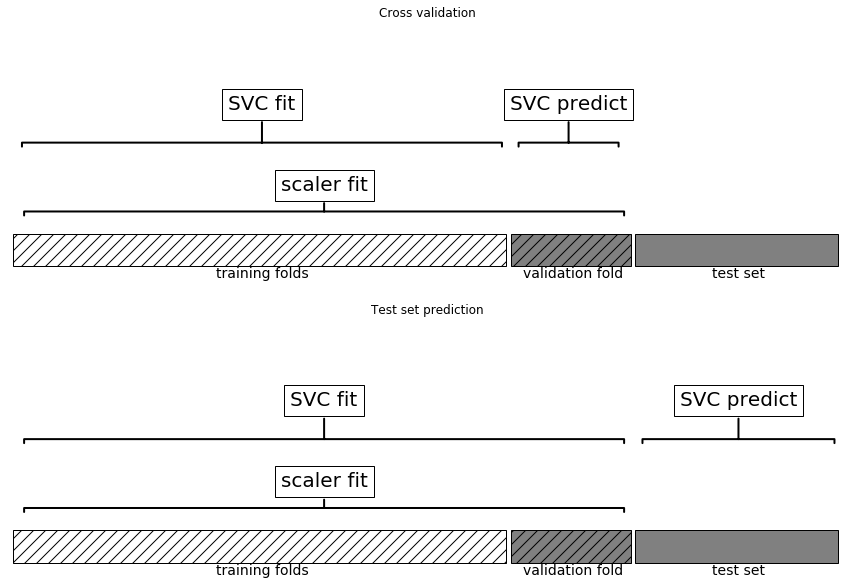

In [4]:
# 교차검증과 실제 test set 예측의 부적절함
# 교차 검증을 할 때엔 모든 훈련 데이터를 scaler fit 하기 때문에, 교차 검증을 할 때 validation fold 또한 scaler fit이 됨
# 하지만, 실제 test set 예측을 할 때, test set은 scaler fit이 되지 않음,
# test set 예측은 교차검증에 비해 올바르지 못하게 반영될 것
mglearn.plots.plot_improper_processing()

In [5]:
# 2. 파이프라인 구축
# 파이프라인에 데이터 전처리, 모델 분류를 표현할 수 있음 (training folds만 적용하고 싶음)
# 즉, 모든 데이터는 해당 파이프라인을 거쳐서 수행하기 때문에, 위와 같은 문제가 발생하지 않음
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler",MinMaxScaler()), ("svm", SVC())])
pipe.fit(X_train, y_train)
print("테스트 점수{}".format(pipe.score(X_test, y_test)))

테스트 점수0.951048951048951


In [6]:
# 3. 그리드서치에 파이프라인 적용하기
param_grid = {'svm__C':[0.001, 0.01, 0.1, 1, 10, 100], 'svm__gamma':[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("최상의 교차 검증 정확도: {}".format(grid.best_score_))
print("테스트 세트 점수: {}".format(grid.score(X_test, y_test)))
print("최적의 매개변수: {}".format(grid.best_params_))

최상의 교차 검증 정확도: 0.9812206572769953
테스트 세트 점수: 0.972027972027972
최적의 매개변수: {'svm__C': 1, 'svm__gamma': 1}


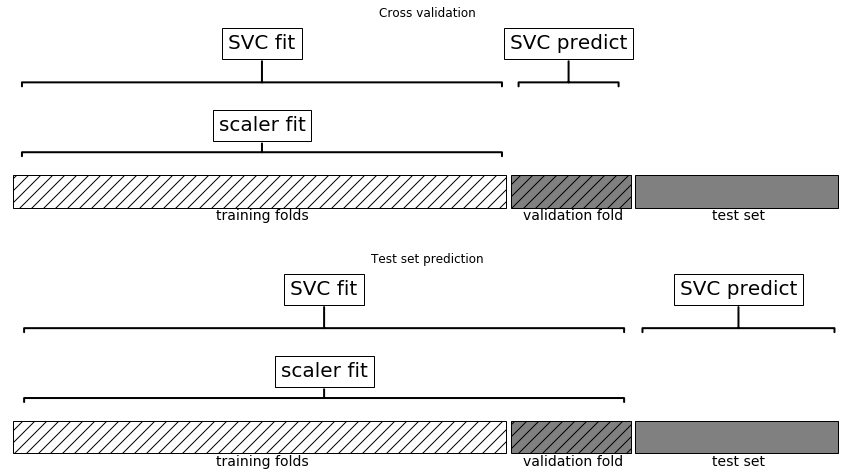

In [7]:
mglearn.plots.plot_proper_processing()

In [14]:
# 4. 파이프라인 인터페이스
# Pipeline은 전처리, 모델 분류에 국한하지 않고 어떤 추정기와도 연결할 수 있음
# 예를 들어, 특성 추출, 특성 선택, 스케일 변경, 분류의 총 네 단계를 포함하는 파이프라인을 만들 수 있음
def fit(self, X, y):
    X_transformed = X
    for name, estimator in self.steps[:-1]:
        X_transformed = estimator.fit_transform(X_transformed, y)
    self.step[-1][1].fit(X_transformed, y)
    return self

def predict(self, X):
    X_transformed = X
    for step in self.steps[:-1]:
        X_transformed = step[1].transform(X_transformed)
    return self.steps[-1][1].predict(X_transformed)

from sklearn.pipeline import make_pipeline
# 표준적인 방법
pipe_long = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC(C=100))])
# 간소화된 방법
pipe_short = make_pipeline(MinMaxScaler(), SVC(C=100))
# 해당 pipeline은 MinMaxScaler(), SVM()을 수행함
print ("파이프라인 단계: \n{}".format(pipe.steps))

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
pipe = make_pipeline(StandardScaler(), PCA(n_components=2), StandardScaler())
print ("파이프라인 단계: \n{}".format(pipe.steps))

파이프라인 단계: 
[('preprocessing', StandardScaler(copy=True, with_mean=True, with_std=True)), ('classifier', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))]
파이프라인 단계: 
[('standardscaler-1', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('standardscaler-2', StandardScaler(copy=True, with_mean=True, with_std=True))]


In [19]:
# 파이프라인의 단계 중 하나의 속성을 확인하고 싶을 때,
pipe.fit(cancer.data)
components = pipe.named_steps["pca"].components_
print("components.shape: {}".format(components.shape))

components.shape: (2, 30)


In [10]:
from sklearn.linear_model import LogisticRegression
# 해당 예제는 그리드 서치를 이용해 StandardScaler, LogisticRegression을 적용한 pipeline
# 그리드 서치를 통해 최적의 파라미터를 찾음
pipe = make_pipeline(StandardScaler(), LogisticRegression())
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=4)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print('최상의 모델\n{}'.format(grid.best_estimator_))
print('로지스틱 회귀 단계 \n{}'.format(grid.best_estimator_.named_steps['logisticregression']))
print('로지스틱 회귀 계수 \n{}'.format(grid.best_estimator_.named_steps['logisticregression'].coef_))

최상의 모델
Pipeline(memory=None,
     steps=[('standardscaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logisticregression', LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])
로지스틱 회귀 단계 
LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
로지스틱 회귀 계수 
[[-0.38856355 -0.37529972 -0.37624793 -0.39649439 -0.11519359  0.01709608
  -0.3550729  -0.38995414 -0.05780518  0.20879795 -0.49487753 -0.0036321
  -0.37122718 -0.38337777 -0.04488715  0.19752816  0.00424822 -0.04857196
   0.21023226  0.22444999 -0.54669761 -0.52542026 -0.49881157 -0.51451071
  -0.3

최적의 매개변수{'polynomialfeatures__degree': 2, 'ridge__alpha': 10}
다항 특성이 있을 때 점수0.7673580350306183
다항 특성이 없을 때 점수:0.6271780381774581


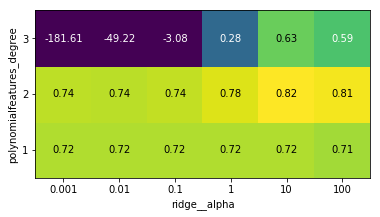

In [21]:
# 5. 전처리와 모델의 매개변수를 위한 그리드 서치
from sklearn.datasets import load_boston
from sklearn.linear_model import Ridge

boston = load_boston()
X_train, X_test, y_train, y_test = train_test_split(boston.data, boston.target, random_state = 0)
from sklearn.preprocessing import PolynomialFeatures
# 다항 특성이 있는 pipeline 적용
pipe = make_pipeline(StandardScaler(), PolynomialFeatures(), Ridge())

param_grid = {'polynomialfeatures__degree':[1,2,3], 'ridge__alpha':[0.001, 0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=1)
grid.fit(X_train, y_train)

# 교차검증의 결과를 히트맵을 통해 나타냄
# 교차검증의 결과를 보면 2차항이 효과가 좋고, 3차항은 1,2차보다 결과가 나쁘며, 최적의 매개변수 또한 확인할 수 있음
# 즉, 그리드서치를 통해 가장 성능이 좋은 전처리 파라미터를 찾아줌
mglearn.tools.heatmap(grid.cv_results_['mean_test_score'].reshape(3,-1),
                     xlabel='ridge__alpha', ylabel='polynomialfeatures_degree',
                     xticklabels=param_grid['ridge__alpha'],
                     yticklabels=param_grid['polynomialfeatures__degree'],
                      vmin=0)

print("최적의 매개변수{}".format(grid.best_params_))
print("다항 특성이 있을 때 점수{}".format(grid.score(X_test, y_test)))

# 다항 특성이 없는 pipeline 적용
param_grid = {'ridge__alpha':[0.001, 0.01, 0.1, 1, 10, 100]}
pipe = make_pipeline(StandardScaler(), Ridge())
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("다항 특성이 없을 때 점수:{}".format(grid.score(X_test, y_test)))

In [12]:
# 6. 모델 선택을 위한 그리드 서치
# 여기선 SVM, RandomForestClassifier 둘 중 가장 최적의 모델을 찾아줄 것
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])
from sklearn.ensemble import RandomForestClassifier

param_grid =[{'classifier':[SVC()], 'preprocessing':[StandardScaler()], 'classifier__gamma':[0.001,0.1,0.1,1,10,100],
             'classifier__C':[0.001,0.01,0.1,1,10,100]},
            {'classifier':[RandomForestClassifier(n_estimators=100)],
            'preprocessing':[None], 'classifier__max_features':[1,2,3]}]

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)

print('최적의 매개변수{}\n'.format(grid.best_params_))
print('최상의 교차 검증 점수{}\n'.format(grid.best_score_))
print('테스트 점수{}\n'.format(grid.score(X_test, y_test)))

최적의 매개변수{'classifier': SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False), 'classifier__C': 100, 'classifier__gamma': 0.001, 'preprocessing': StandardScaler(copy=True, with_mean=True, with_std=True)}

최상의 교차 검증 점수0.9812206572769953

테스트 점수0.986013986013986

